In [136]:
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

In [137]:
# load in the dataset from kaggle
import kagglehub

# set path
path = kagglehub.dataset_download("vipullrathod/fish-market")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fish-market


In [138]:
# turn path into pandas df via csv reader
df = pd.read_csv(path + "/Fish.csv")

In [139]:
df.tail()

,Species,Weight,Length1,Length2,Length3,Height,Width
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
158,Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792


In [140]:
df.shape

(159, 7)

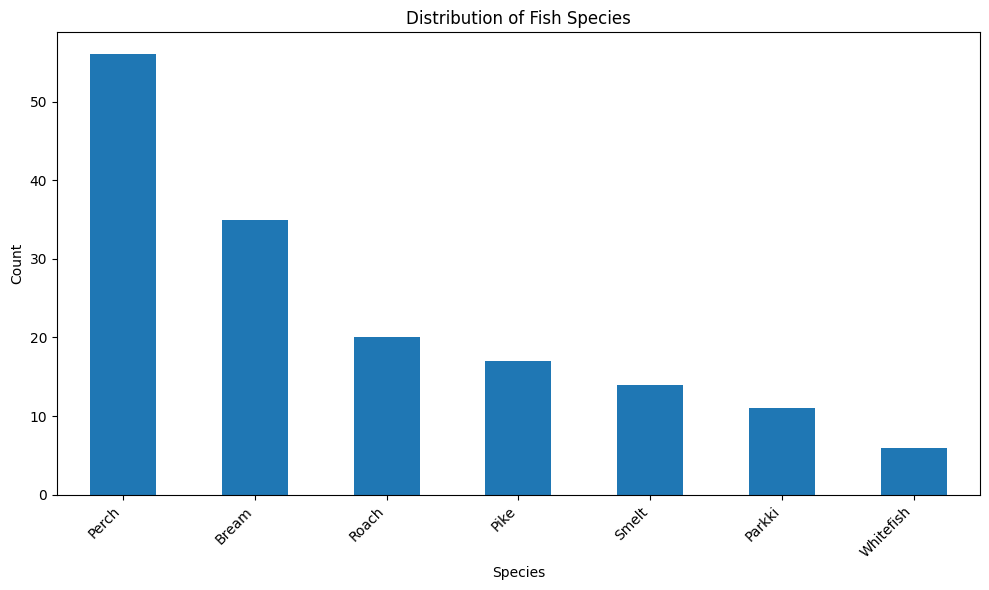

In [141]:
# Plot species distribution (target variable)
# Need to figure out how to account for distribution differences

import matplotlib.pyplot as plt
# Count the occurrences of each species
species_counts = df['Species'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar')
plt.title('Distribution of Fish Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [142]:
# Check target values and encode them numerically
species = df['Species'].unique()
num_target = {key: value for value, key in enumerate(species)}

In [143]:
num_target

{'Bream': 0,
 'Roach': 1,
 'Whitefish': 2,
 'Parkki': 3,
 'Perch': 4,
 'Pike': 5,
 'Smelt': 6}

In [144]:
# encode target variables for neural network
df['Species'] = df['Species'].map(num_target)


In [145]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,0,290.0,24.0,26.3,31.2,12.4800,4.3056
2,0,340.0,23.9,26.5,31.1,12.3778,4.6961
3,0,363.0,26.3,29.0,33.5,12.7300,4.4555
4,0,430.0,26.5,29.0,34.0,12.4440,5.1340


In [146]:
class FishModel(nn.Module):
  # input layer has 6 characteristics of fish species
  # 2 hidden layers (neurons)
  # output layer as 7 species type of fish
  def __init__(self, input_features = 6, layer1 = 8, layer2 = 9, output_features = 7):
    super().__init__()
    self.fc1 = nn.Linear(input_features, layer1)
    self.fc2 = nn.Linear(layer1, layer2)
    self.out = nn.Linear(layer2, output_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x


In [147]:
# intialize a random state parameter for reproducability, and define model
torch.manual_seed(13)
model = FishModel()

In [148]:
# Seperate the values into features and targets (x,y) respecitively
X = df.drop('Species', axis = 1)
y = df['Species']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=13, stratify=y)


In [149]:
print(X.dtypes, y.dtypes)

Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object int64


##Feature Engineering

In [150]:
from sklearn.preprocessing import StandardScaler
# Make sure features are the same scale to improve model performance
scalar = StandardScaler().fit(x_train)
x_trained_scaled = scalar.transform(x_train)
x_test_scaled = scalar.transform(x_test)


In [151]:
# Fit into a dataframe to feed into Tensor dtype
x_trained_scaled = pd.DataFrame(x_trained_scaled, columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns)
x_trained_scaled.head()

,Weight,Length1,Length2,Length3,Height,Width
0,-0.729331,-0.735320,-0.730993,-0.702862,-0.124923,-0.685965
1,0.639555,0.453549,0.451045,0.617856,1.248278,0.748218
2,-1.051690,-1.250497,-1.257370,-1.299316,-1.421600,-1.520116
3,-0.756172,-0.636248,-0.610943,-0.677300,-0.686491,-0.550044
4,-0.702490,-0.794764,-0.795636,-0.771028,-0.042756,-0.686908


In [152]:
# Make train/test frames into tensors

x_train = torch.FloatTensor(x_trained_scaled.values)
x_test = torch.FloatTensor(x_test_scaled.values)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)


In [153]:
# Set criterion of model to measure the error
criterian = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [154]:
epochs = 257
losses = []
# print every 2^i losses
powers = [2**k for k in range(1,11)]

for i in range(epochs):
  y_pred = model.forward(x_train)

  # measure loss
  loss = criterian(y_pred, y_train)
  losses.append(loss.detach().numpy())

  if i in powers:
    print(f'Epoch: {i} Loss: {loss}')


  # backprop
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()


Epoch: 2 Loss: 2.016169786453247
Epoch: 4 Loss: 1.9726567268371582
Epoch: 8 Loss: 1.8787481784820557
Epoch: 16 Loss: 1.6120473146438599
Epoch: 32 Loss: 1.0926920175552368
Epoch: 64 Loss: 0.45219218730926514
Epoch: 128 Loss: 0.22130809724330902
Epoch: 256 Loss: 0.08596327155828476


Epoch 257 | Loss 0.0860 | Val Acc 96.88%


FishModel(
  (fc1): Linear(in_features=6, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=7, bias=True)
)

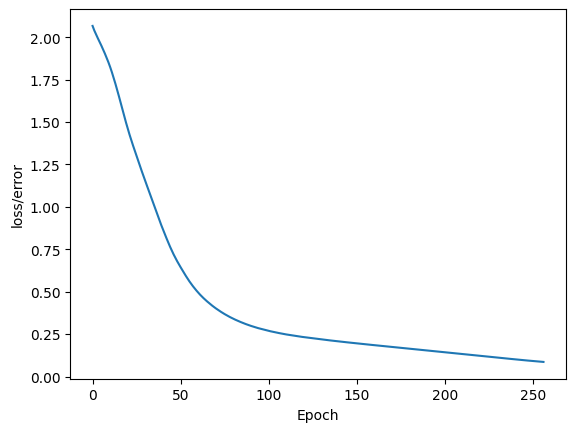

In [155]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

model.eval()
with torch.no_grad():
    val_preds = model(x_test).argmax(dim=1)
    val_acc   = (val_preds == y_test).float().mean()
print(f"Epoch {epochs:3d} | Loss {loss:.4f} | Val Acc {val_acc:.2%}")
model.train()


In [156]:
# Evaluate Model
with torch.no_grad(): # turn off back propogation
  y_eval = model.forward(x_test)
  loss = criterian(y_eval, y_test)


In [157]:
loss

tensor(0.1183)

In [158]:
# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert predicted probabilities to predicted classes
y_pred_class = torch.argmax(y_eval, dim=1)

# Convert tensors to numpy arrays for sklearn metrics
y_test_np = y_test.numpy()
y_pred_class_np = y_pred_class.numpy()

# Evaluate the model using sklearn metrics
print("Classification Report:")
print(classification_report(y_test_np, y_pred_class_np, target_names=species))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_np, y_pred_class_np))

print("\nAccuracy Score:")
print(accuracy_score(y_test_np, y_pred_class_np))


Classification Report:
              precision    recall  f1-score   support

       Bream       1.00      1.00      1.00         7
       Roach       0.80      1.00      0.89         4
   Whitefish       0.00      0.00      0.00         1
      Parkki       1.00      1.00      1.00         2
       Perch       1.00      1.00      1.00        11
        Pike       1.00      1.00      1.00         4
       Smelt       1.00      1.00      1.00         3

    accuracy                           0.97        32
   macro avg       0.83      0.86      0.84        32
weighted avg       0.94      0.97      0.95        32


Confusion Matrix:
[[ 7  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  0 11  0  0]
 [ 0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  3]]

Accuracy Score:
0.96875


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
